In [1]:
from qiskit.circuit.library import QAOAAnsatz

import parity_network
import importlib
import numpy as np

#### This one is for 4-sat with 5 qubits.
#### The clauses are : (x₀ ∨ ¬x₁ ∨ x₂ ∨ ¬x₃) ^ (¬x₀ ∨ x₁ ∨ ¬x₂ ∨ x₄) ^ (¬x₁ ∨ x₂ ∨ ¬x₃ ∨ ¬x₄)

In [46]:
num_qubits = 5

In [ ]:
from qiskit import QuantumCircuit


def cnot_count(circuit: QuantumCircuit) -> int:
    return circuit.count_ops().get("cx", 0)

In [47]:
importlib.reload(parity_network)

parity, term_dict = parity_network.main(num_qubits)

parity_ansatz = QAOAAnsatz(parity, reps=10)
parity_ansatz.measure_all()

# parity_ansatz.decompose().draw("mpl")

Parities and Weights of the Hamiltonian:
{'00000': 0.1875, '01000': -0.0625, '00100': 0.0625, '00010': -0.125, '11000': -0.125, '10100': 0.125, '10010': -0.0625, '10001': -0.0625, '01100': -0.1875, '01010': 0.125, '01001': 0.125, '00110': -0.125, '00101': -0.125, '00011': 0.0625, '11010': 0.0625, '11001': -0.0625, '10110': -0.0625, '10101': 0.0625, '01110': 0.125, '01011': -0.0625, '00111': 0.0625, '11110': 0.0625, '11101': 0.0625, '01111': -0.0625}

Forward Circuit with Rz gates:
                                                                     »
q_0: ────────────────────■─────────────────────■──────────────────■──»
     ┌────────────────┐┌─┴─┐┌───────────────┐  │                  │  »
q_1: ┤ Rz((-0.125)*γ) ├┤ X ├┤ Rz((-0.25)*γ) ├──┼──────────────────┼──»
     └┬─────────────┬─┘└───┘└───────────────┘┌─┴─┐┌────────────┐  │  »
q_2: ─┤ Rz(0.125*γ) ├────────────────────────┤ X ├┤ Rz(0.25*γ) ├──┼──»
     ┌┴─────────────┴┐                       └───┘└────────────┘┌─┴─┐»
q_3: ┤ Rz((-0.25)

In [5]:
from qiskit.quantum_info import SparsePauliOp


def get_hamiltonian_observable(term_dict, n_qubits):
    """Converts a dictionary of bitstrings and weights into a Qiskit SparsePauliOp observable."""
    pauli_list = []
    coeff_list = []
    for bitstring, weight in term_dict.items():
        pauli_str = ["I"] * n_qubits
        for i, bit in enumerate(bitstring):
            if bit == "1":
                pauli_str[n_qubits - 1 - i] = "Z"
        pauli_list.append("".join(pauli_str))
        coeff_list.append(weight)

    return SparsePauliOp(pauli_list, coeffs=coeff_list)

In [48]:
from scipy.optimize import minimize
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2 as AerEstimator
from qiskit.compiler import transpile

backend = AerSimulator()
estimator = AerEstimator()
estimator.options.shots = 10000

parity_ansatz_isa = transpile(parity_ansatz, backend=backend)

obs = get_hamiltonian_observable(term_dict, num_qubits)
print(obs)
print("CNOT count :", cnot_count(parity_ansatz_isa))

SparsePauliOp(['IIIII', 'IIIZI', 'IIZII', 'IZIII', 'IIIZZ', 'IIZIZ', 'IZIIZ', 'ZIIIZ', 'IIZZI', 'IZIZI', 'ZIIZI', 'IZZII', 'ZIZII', 'ZZIII', 'IZIZZ', 'ZIIZZ', 'IZZIZ', 'ZIZIZ', 'IZZZI', 'ZZIZI', 'ZZZII', 'IZZZZ', 'ZIZZZ', 'ZZZZI'],
              coeffs=[ 0.1875+0.j, -0.0625+0.j,  0.0625+0.j, -0.125 +0.j, -0.125 +0.j,
  0.125 +0.j, -0.0625+0.j, -0.0625+0.j, -0.1875+0.j,  0.125 +0.j,
  0.125 +0.j, -0.125 +0.j, -0.125 +0.j,  0.0625+0.j,  0.0625+0.j,
 -0.0625+0.j, -0.0625+0.j,  0.0625+0.j,  0.125 +0.j, -0.0625+0.j,
  0.0625+0.j,  0.0625+0.j,  0.0625+0.j, -0.0625+0.j])
CNOT count : 310


In [49]:
parity_cost_history_dict = {
    "iters": 0,
    "cost_history": [],
}


def initialize_cost_history_dict(cost_history_dict):
    cost_history_dict["iters"] = 0
    cost_history_dict["cost_history"] = []

In [8]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator, cost_history_dict):

    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    cost_history_dict["iters"] += 1
    cost_history_dict["cost_history"].append(cost)
    print(f"Iters {cost_history_dict['iters']}: Current cost: {cost}")

    return cost

In [50]:
params_init = np.random.rand(parity_ansatz_isa.num_parameters) * 2 * np.pi
initialize_cost_history_dict(parity_cost_history_dict)

result_parity = minimize(
    cost_func_estimator,
    params_init,
    args=(parity_ansatz_isa, obs, estimator, parity_cost_history_dict),
    method="COBYLA",
)

Iters 1: Current cost: 0.3271484375
Iters 2: Current cost: 0.3876953125
Iters 3: Current cost: 0.626953125
Iters 4: Current cost: 0.349609375
Iters 5: Current cost: 0.544921875
Iters 6: Current cost: 0.4951171875
Iters 7: Current cost: 0.515625
Iters 8: Current cost: 0.5771484375
Iters 9: Current cost: 0.396484375
Iters 10: Current cost: 0.4248046875
Iters 11: Current cost: 0.3955078125
Iters 12: Current cost: 0.2880859375
Iters 13: Current cost: 0.2880859375
Iters 14: Current cost: 0.2392578125
Iters 15: Current cost: 0.2138671875
Iters 16: Current cost: 0.1728515625
Iters 17: Current cost: 0.109375
Iters 18: Current cost: 0.34375
Iters 19: Current cost: 0.1552734375
Iters 20: Current cost: 0.1767578125
Iters 21: Current cost: 0.3369140625
Iters 22: Current cost: 0.63671875
Iters 23: Current cost: 0.3134765625
Iters 24: Current cost: 0.513671875
Iters 25: Current cost: 0.5751953125
Iters 26: Current cost: 0.2744140625
Iters 27: Current cost: 0.2060546875
Iters 28: Current cost: 0.4726

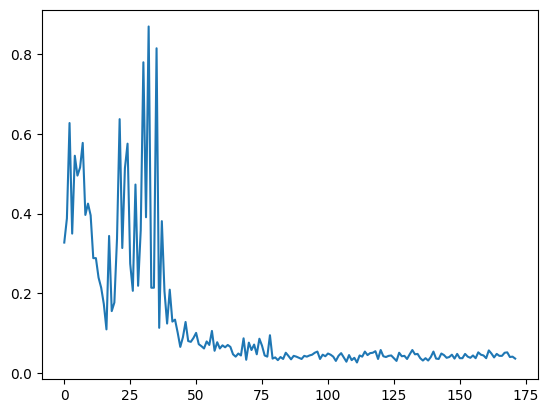

In [51]:
import matplotlib.pyplot as plt

plt.plot(parity_cost_history_dict["cost_history"])

In [52]:
naive_ansatz = QAOAAnsatz(obs, reps=10)
naive_ansatz.measure_all()

# naive_ansatz.decompose().draw("mpl")

In [53]:
naive_ansatz_isa = transpile(naive_ansatz, backend=backend)

print("CNOT count :", cnot_count(naive_ansatz_isa))

CNOT count : 440


In [54]:
naive_cost_history_dict = {
    "iters": 0,
    "cost_history": [],
}

In [55]:
params_init = np.random.rand(naive_ansatz_isa.num_parameters) * 2 * np.pi
initialize_cost_history_dict(naive_cost_history_dict)

result_naive = minimize(
    cost_func_estimator,
    params_init,
    args=(naive_ansatz_isa, obs, estimator, naive_cost_history_dict),
    method="COBYLA",
)

Iters 1: Current cost: 0.1796875
Iters 2: Current cost: 0.236328125
Iters 3: Current cost: 0.25390625
Iters 4: Current cost: 0.3984375
Iters 5: Current cost: 0.4228515625
Iters 6: Current cost: 0.61328125
Iters 7: Current cost: 0.619140625
Iters 8: Current cost: 0.4169921875
Iters 9: Current cost: 0.3466796875
Iters 10: Current cost: 0.341796875
Iters 11: Current cost: 0.30859375
Iters 12: Current cost: 0.36328125
Iters 13: Current cost: 0.2236328125
Iters 14: Current cost: 0.2490234375
Iters 15: Current cost: 0.4404296875
Iters 16: Current cost: 0.18359375
Iters 17: Current cost: 0.2421875
Iters 18: Current cost: 0.0888671875
Iters 19: Current cost: 0.0830078125
Iters 20: Current cost: 0.0712890625
Iters 21: Current cost: 0.099609375
Iters 22: Current cost: 0.3037109375
Iters 23: Current cost: 0.228515625
Iters 24: Current cost: 0.09375
Iters 25: Current cost: 0.197265625
Iters 26: Current cost: 0.1005859375
Iters 27: Current cost: 0.06640625
Iters 28: Current cost: 0.1005859375
Iters

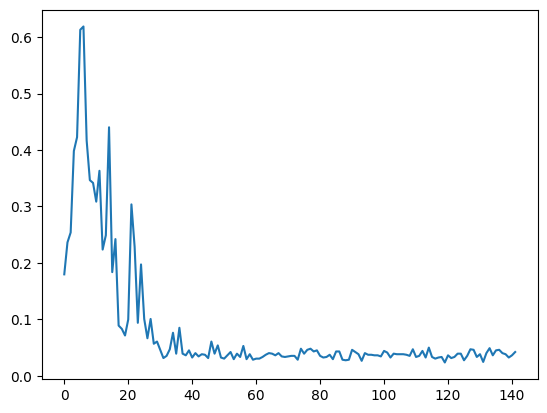

In [56]:
plt.plot(naive_cost_history_dict["cost_history"])

### Sampler

In [57]:
optimized_parity_ansatz = parity_ansatz_isa.assign_parameters(result_parity.x)

In [ ]:
from qiskit_aer.primitives import SamplerV2 as AerSampler

sampler = AerSampler()
sampler.options.shots = 10000

parity_job = sampler.run([optimized_parity_ansatz])
parity_res = parity_job.result()

In [59]:
counts = parity_res[0].data.meas.get_counts()
most_likely_bitstring = max(counts, key=counts.get)

print(f"\nMost likely solution bitstring: {most_likely_bitstring}")


Most likely solution bitstring: 10101


In [60]:
optimized_naive_ansatz = parity_ansatz_isa.assign_parameters(result_naive.x)

In [61]:
naive_job = sampler.run([optimized_naive_ansatz])
naive_res = naive_job.result()

counts = naive_res[0].data.meas.get_counts()
most_likely_bitstring = max(counts, key=counts.get)

print(f"\nMost likely solution bitstring: {most_likely_bitstring}")


Most likely solution bitstring: 10100


### Only the parity synthesis one is the correct answer.

## Noise AerSimulator

In [33]:
from qiskit_aer.noise import NoiseModel, depolarizing_error

noise_model = NoiseModel()
cx_depolarizing_prob = 0.02
noise_model.add_all_qubit_quantum_error(
    depolarizing_error(cx_depolarizing_prob, 2), ["cx"]
)

noisy_estimator = AerEstimator(
    options=dict(backend_options=dict(noise_model=noise_model))
)

In [34]:
noisy_parity_cost_history_dict = {
    "iters": 0,
    "cost_history": [],
}

In [35]:
params_init = np.random.rand(parity_ansatz_isa.num_parameters) * 2 * np.pi
initialize_cost_history_dict(noisy_parity_cost_history_dict)

result_noisy_parity = minimize(
    cost_func_estimator,
    params_init,
    args=(parity_ansatz_isa, obs, noisy_estimator, noisy_parity_cost_history_dict),
    method="COBYLA",
)

Iters 1: Current cost: 0.23148535156250008
Iters 2: Current cost: 0.22661171874999997
Iters 3: Current cost: 0.21682421874999994
Iters 4: Current cost: 0.1963468750000001
Iters 5: Current cost: 0.2129267578125
Iters 6: Current cost: 0.19341738281249996
Iters 7: Current cost: 0.2334400390625
Iters 8: Current cost: 0.20513925781249995
Iters 9: Current cost: 0.20707910156249992
Iters 10: Current cost: 0.23052070312499998
Iters 11: Current cost: 0.22562753906250002
Iters 12: Current cost: 0.2304970703124999
Iters 13: Current cost: 0.23343652343750007
Iters 14: Current cost: 0.21882226562500007
Iters 15: Current cost: 0.21196464843750004
Iters 16: Current cost: 0.21392910156249992
Iters 17: Current cost: 0.22464921875
Iters 18: Current cost: 0.2275697265625
Iters 19: Current cost: 0.19832128906249993
Iters 20: Current cost: 0.23732539062499997
Iters 21: Current cost: 0.23831601562500002
Iters 22: Current cost: 0.1983210937499999
Iters 23: Current cost: 0.2441830078124999
Iters 24: Current c

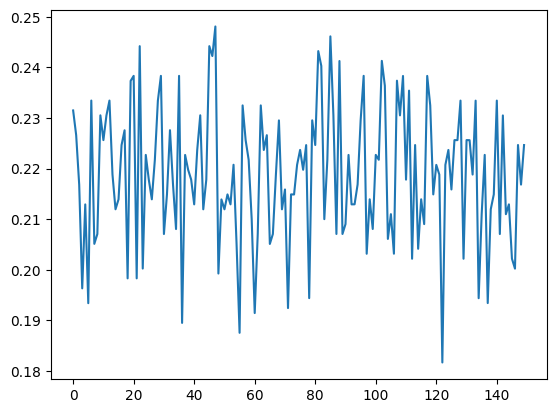

In [36]:
plt.plot(noisy_parity_cost_history_dict["cost_history"])

In [20]:
noisy_naive_cost_history_dict = {
    "iters": 0,
    "cost_history": [],
}

In [37]:
params_init = np.random.rand(naive_ansatz_isa.num_parameters) * 2 * np.pi
initialize_cost_history_dict(noisy_naive_cost_history_dict)

result_naive = minimize(
    cost_func_estimator,
    params_init,
    args=(naive_ansatz_isa, obs, noisy_estimator, noisy_naive_cost_history_dict),
    method="COBYLA",
)

Iters 1: Current cost: 0.2149013671875
Iters 2: Current cost: 0.23148906249999998
Iters 3: Current cost: 0.2178236328125
Iters 4: Current cost: 0.22074746093750003
Iters 5: Current cost: 0.24027890624999995
Iters 6: Current cost: 0.21393359375000007
Iters 7: Current cost: 0.1963480468749999
Iters 8: Current cost: 0.19634531250000004
Iters 9: Current cost: 0.21685175781249996
Iters 10: Current cost: 0.221720703125
Iters 11: Current cost: 0.18463222656249997
Iters 12: Current cost: 0.2197765624999999
Iters 13: Current cost: 0.2197794921875001
Iters 14: Current cost: 0.21394980468750005
Iters 15: Current cost: 0.22756738281249989
Iters 16: Current cost: 0.22270449218749994
Iters 17: Current cost: 0.2119802734375001
Iters 18: Current cost: 0.22759453125000004
Iters 19: Current cost: 0.21391328124999995
Iters 20: Current cost: 0.24516406249999997
Iters 21: Current cost: 0.21100449218749998
Iters 22: Current cost: 0.22761523437499998
Iters 23: Current cost: 0.23246738281249993
Iters 24: Curr

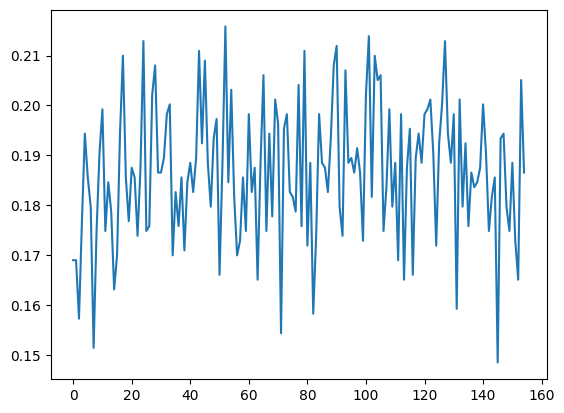

In [22]:
plt.plot(noisy_naive_cost_history_dict["cost_history"])